In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

**#Load the dataset**

In [60]:
#from google.colab import files
#uploaded = files.upload()
#
#import numpy as np
#import os
#import math
#import shutil
#import glob
#
#
#import zipfile
#import gdown
#from PIL import Image

# Assume the file name is 'example.csv'
from google.colab import drive
#drive.mount('/content/drive')

data = pd.read_csv('/content/drive//My Drive/Colab Notebooks/NEW DATASET PCOS 23.csv')



In [61]:
data.head()

,P_NO,P_NAME,PCOS,AGE,WEIGHT,HEIGHT,BMI,BG,PR,RR,...,HG,SD,HL,PIMPLES,FF,RE,BP_SYSTOLIC,BP_DIASTOLIC,FN,ULT_REP
0,1,Aadhira,1,38,89.9,150.2,25.4,O+,78,18,...,0,1,1,0,0,1,98,61,10,https://drive.google.com/file/d/119rnauh4Kl-_2...
1,2,Aadya,0,31,88.6,179.8,30.7,O+,72,15,...,0,0,1,1,1,0,117,63,7,https://drive.google.com/file/d/1276RwMFtdmGOW...
2,3,Aahana,0,40,68.6,165.6,20.2,AB-,85,15,...,1,0,1,0,1,0,102,87,9,https://drive.google.com/file/d/1KOeuXcxpS6flQ...
3,4,Aalia,0,36,91.8,171.0,26.9,B-,99,12,...,0,1,1,1,1,1,129,77,6,https://drive.google.com/file/d/1LRrgzKqbNl0Z3...
4,5,Aanya,0,36,95.1,177.5,27.9,A-,79,19,...,0,1,0,0,1,1,100,81,9,https://drive.google.com/file/d/1N4mNLXu6ay1qN...


**# Data preprocessing**

Label_encoder converts categorical labels into a numerical form.

In [66]:

label_encoder = LabelEncoder()
data['BG'] = label_encoder.fit_transform(data['BG'])
data['ULT_REP'] = label_encoder.fit_transform(data['ULT_REP'])
data['P_NAME'] = label_encoder.fit_transform(data['P_NAME'])

**# Splitting the data into features and target**

In [67]:
X = data.drop(columns=['P_NO', 'PCOS'])
y = data['PCOS']

**# Balancing the dataset using SMOTE**

In [68]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [69]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**# StandardScaler() it transforms the data so that it has a mean of 0 and a standard deviation of 1**


In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**# Feature Engineering for Logistic Regression (Polynomial Features)**

In [71]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

**# Logistic Regression with Hyperparameter Tuning**

In [72]:
logistic_model = LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear')
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_poly, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

In [73]:
best_logistic_model = grid_search.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test_poly)

**Logistic Regression Results**

In [74]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

**# CNN Model with Dropout Regularization**


In [75]:
cnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

y_pred_cnn = cnn_model.predict(X_test_scaled).round()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


**# CNN Results**


In [76]:
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
report_cnn = classification_report(y_test, y_pred_cnn)

**# Visualization** and Accuracy Comparison **


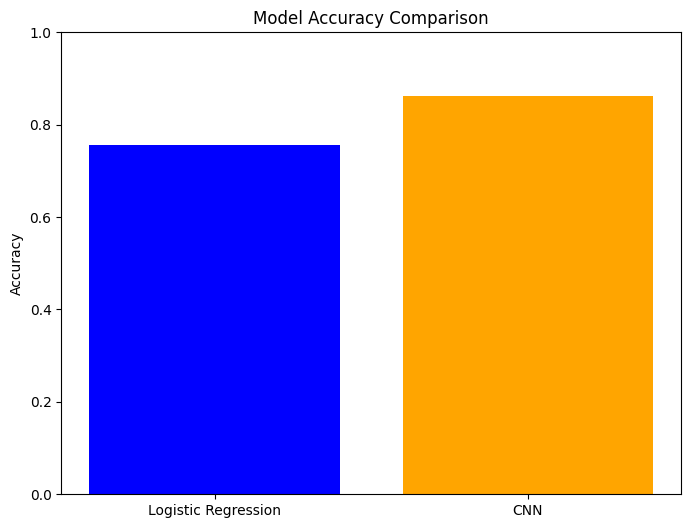

In [77]:
plt.figure(figsize=(8, 6))
model_names = ['Logistic Regression', 'CNN']
accuracies = [accuracy_logistic, accuracy_cnn]
plt.bar(model_names, accuracies, color=['blue', 'orange'])
plt.ylim([0, 1])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

**# Confusion Matrices**


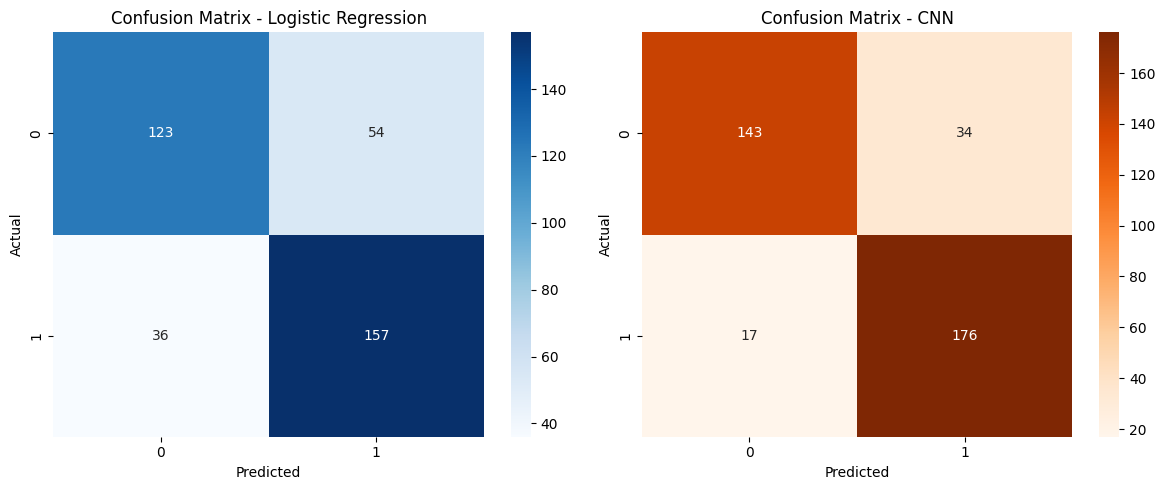

In [78]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

**Receiver operating Charachteristics (ROC) Curves**

In [79]:
# ROC Curves
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, best_logistic_model.decision_function(X_test_poly))
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

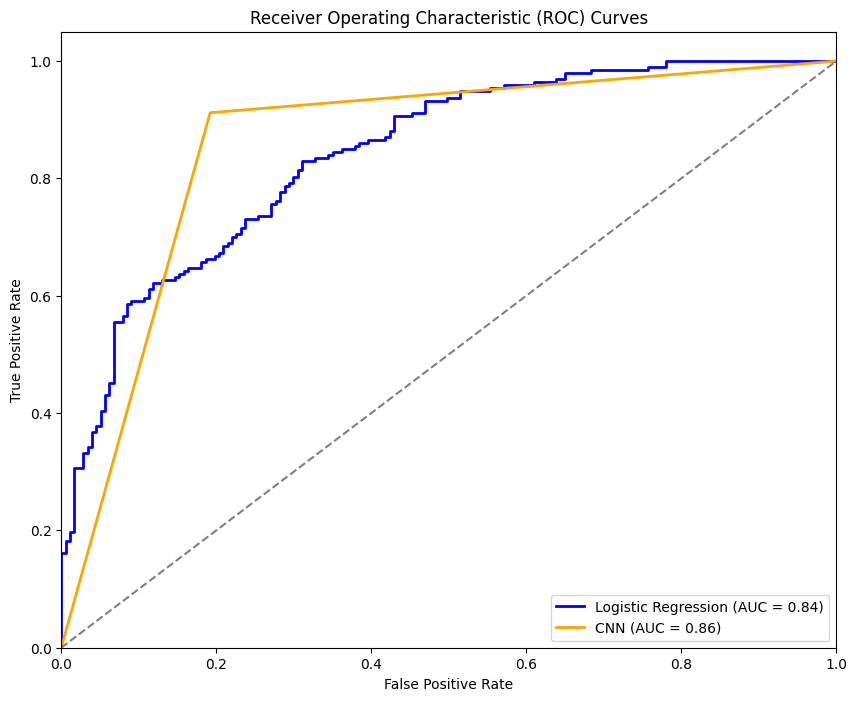

In [80]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot(fpr_cnn, tpr_cnn, color='orange', lw=2, label=f'CNN (AUC = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

**-----------Output------------**

**Logistic Regression Accuracy**

**CNN Accuracy**

In [81]:
print(f"Logistic Regression Accuracy: {accuracy_logistic}")
print(f"Logistic Regression Classification Report:\n{report_logistic}")
print(f"CNN Accuracy: {accuracy_cnn}")
print(f"CNN Classification Report:\n{report_cnn}")

Logistic Regression Accuracy: 0.7567567567567568
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       177
           1       0.74      0.81      0.78       193

    accuracy                           0.76       370
   macro avg       0.76      0.75      0.75       370
weighted avg       0.76      0.76      0.76       370

CNN Accuracy: 0.8621621621621621
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       177
           1       0.84      0.91      0.87       193

    accuracy                           0.86       370
   macro avg       0.87      0.86      0.86       370
weighted avg       0.86      0.86      0.86       370



**Applying XG Boost on Logistic Regression**

In [82]:
# XGBoost Model

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=len(y_resampled)/sum(y_resampled))

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

# Output Results
print(f"Accuracy: {accuracy_xgb}")
print("Confusion Matrix:\n", conf_matrix_xgb)
print("Classification Report:\n", report_xgb)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Accuracy: 0.9108108108108108
Confusion Matrix:
 [[159  18]
 [ 15 178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       177
           1       0.91      0.92      0.92       193

    accuracy                           0.91       370
   macro avg       0.91      0.91      0.91       370
weighted avg       0.91      0.91      0.91       370



**Plotting Heatmap for Correlation**

In [94]:
df=data[['PCOS', 'CYCLE', 'CL', 'MS', 'P', 'AB', 'BETA_I', 'FSH', 'LH',
       'FSH_LH', 'HIP', 'WAIST', 'HIP_RATIO', 'TSH', 'PRL', 'VIT_D3', 'PRG',
       'RBS', 'WG', 'HG', 'SD', 'HL', 'PIMPLES', 'FF', 'RE', 'BP_SYSTOLIC',
       'BP_DIASTOLIC', 'FN']]

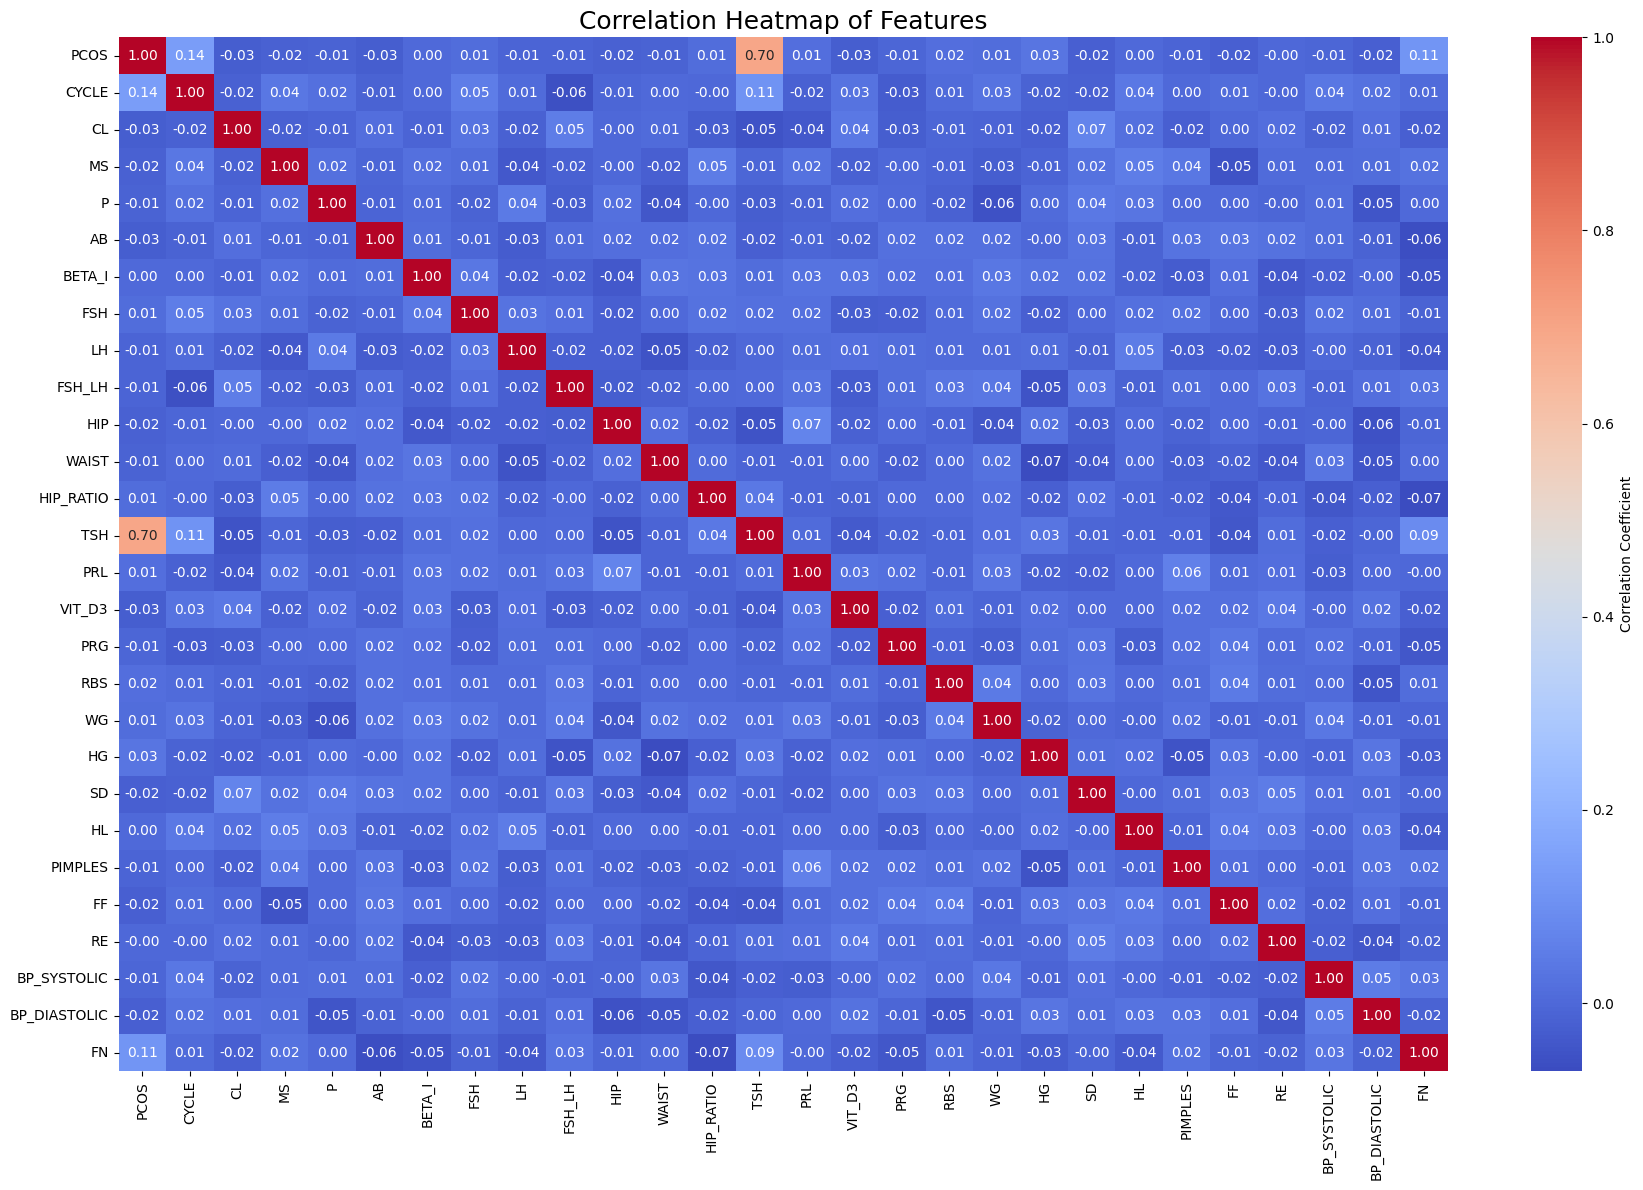

In [97]:
plt.figure(figsize=(18, 12))
heatmap = sns.heatmap(
    df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',  # Format annotations to 2 decimal places
    annot_kws={'size': 10},  # Increase annotation font size
    cbar_kws={'label': 'Correlation Coefficient'}  # Add label to the color bar
)

# Add a title
plt.title('Correlation Heatmap of Features', fontsize=18)

plt.tight_layout()
plt.show()

**Plotting Box Plot for a selected feature (e.g., BMI)**

<ipython-input-99-dc465d67f478>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PCOS', y='BMI', data=data, palette='Set3')


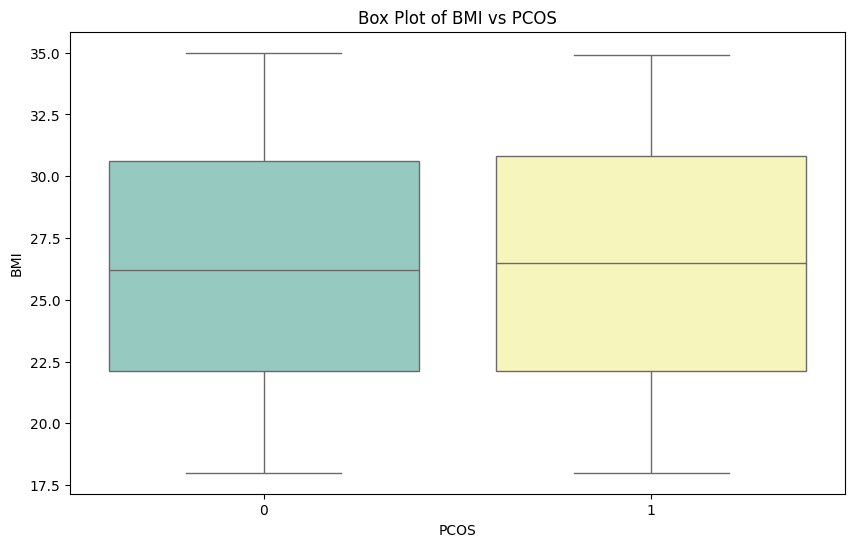

In [99]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PCOS', y='BMI', data=data, palette='Set3')

plt.title('Box Plot of BMI vs PCOS')

# Customize x-axis and y-axis labels if needed
plt.xlabel('PCOS')
plt.ylabel('BMI')

plt.show()

**# Plotting Scatter Plot for selected features (e.g., Age vs Weight)**

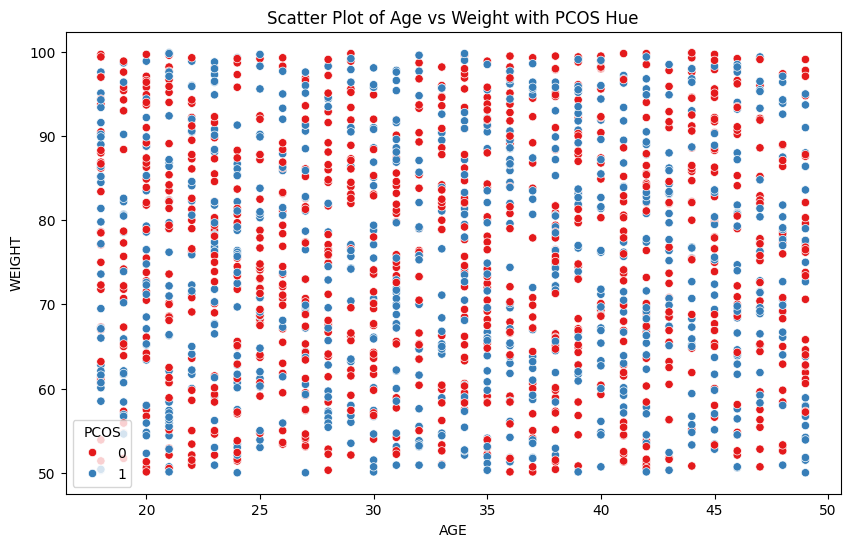

In [101]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE', y='WEIGHT', hue='PCOS', palette='Set1', data=data)
plt.title('Scatter Plot of Age vs Weight with PCOS Hue')

plt.legend(title='PCOS')

plt.show()
